# Preamble 
L'objectif de ce document est de présenter un algorithme de détermination de l'angle d'une remorque à l'arrière d'un véhicule équipé d'une caméra vidéo.


# import
Le programme écrit en python s'appuie sur plusieurs bibliothèques existantes standard.

In [1]:
import cv2
print(cv2.__version__)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
import pandas as pd
import os
from numba import jit
from scipy.signal import find_peaks

4.1.0


# File selection

In [2]:
path = "/Users/oliviermanette/Desktop/trailer detection challenge/data/P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx"
os.chdir(path)

In [3]:
pwd

'/Users/oliviermanette/Desktop/trailer detection challenge/data/P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx'

In [4]:
ls

P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx.avi*
P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx.dat_GT.csv*


In [5]:
#fileName='W420_ES_Hi_Snow_Slush_Asphalt_28klux.avi'
fileName = 'P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx.avi'

# Test Video Loop

In [6]:
cap = cv2.VideoCapture(fileName)  # load the video
while (cap.isOpened()):  # play the video by reading frame by frame
    ret, frame = cap.read()
    if ret == True:
        # optional: do some image processing here
        cv2.imshow('frame', frame)
        # show the video
        if cv2.waitKey(1) & 0xFF == ord('q'):
            #if 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

# Variables globales
Pour des raisons de lisibilité du code, l'ensemble des variables locales seront précédés du préfixe 'l' afin de les différencier des variables globales qui n'ont pas de préfixe.
## Type de données de position

In [7]:
posType = np.dtype([('x', 'u1'), ('y', 'u2')])

## Type de données de Neurones
### Neurone sensoriel à champs récepteur

In [8]:
NeuronType = np.dtype([('longueur', 'u1'), ('angle', 'f4'), ('weight', 'f4'),
                       ('precision', 'f4'), ('xPos', 'u1'), ('yPos', 'u2'),
                       ('groupID', 'u1'), ('layer', 'f4')])

## Taille des champs récepteurs neuronaux

In [9]:
tailleField = 7

# Fonctions
## Calcul d'un neurone champ moyen
A partir d'une liste de neurones, il retourne le neurone moyen

In [10]:
def getAvgFieldNeuron(lNeuronList, typeList=NeuronType):
    lNeurons = np.zeros(1, dtype=typeList)
    lpNeurons = pd.DataFrame(lNeurons)
    lpNeurons['longueur'] = int(lNeuronList.longueur[0:1])
    lpNeurons['angle'] = float(
        np.sum((lNeuronList.angle * lNeuronList.weight) /
               np.sum(lNeuronList.weight)))
    lpNeurons['weight'] = float(
        np.sum((lNeuronList.weight * lNeuronList.weight) /
               np.sum(lNeuronList.weight)))
    lpNeurons['precision'] = float(
        np.sum((lNeuronList.precision * lNeuronList.weight) /
               np.sum(lNeuronList.weight)))
    lpNeurons['xPos'] = np.around(
        np.sum((lNeuronList.xPos * lNeuronList.weight)) /
               np.sum(lNeuronList.weight))
    lpNeurons['yPos'] = np.around(
        np.sum((lNeuronList.yPos * lNeuronList.weight)) /
               np.sum(lNeuronList.weight))
    return lpNeurons

## Matrice des directions
Afin de faciliter le calcul des angles des pixels, une matrice de poids est générée afin d'appliquer à chaque pixel centré sur un champs récepteur un poids correspondant à l'angle d'une ligne passant par ce centre.
Voici comment les angles sont représentés <br> <b>IMAGE</b>

In [11]:
@jit(nopython=True, parallel=True)
def fillAngleMat(lSize):
    lOutput = np.zeros((lSize, lSize))
    lOffset = int(np.floor(lSize / 2))
    for lX in range(0, lSize):
        for lY in range(0, lSize):
            if (lX - lOffset) == 0:
                lOutput[lX, lY] = 90
            else:
                lOutput[lX, lY] = 0.01 + np.around(
                    np.arctan((lY - lOffset) / (lOffset - lX)) / pi * 180, 2)
    lOutput[lOffset, lOffset] = 0
    return lOutput

## Fonction d'activation des neurones
Chaque neurone retourne une valeur comprise entre 0 et 255 qui reflète son niveau d'activation. Cette activation reflète le niveau de confiance que le neurone a sur le lien existant entre sa fonction de base et les pixels reçus dans son champs récepteur. Plus les pixels sont organisés de façon à former une ligne avec l'angle correspondant à la fonction de base du neurone et plus ce dernier sera activé. Comme on ne souhaite pas obtenir une activation de valeur infinie, on utilise donc une fonction sigmoide qui s'applique à l'écart-type des angles supposés. 

In [12]:
@jit(nopython=True, parallel=True)
def sigmoidActivationFctN1(lActivationVector):
    lDenom = (1 + np.exp(0.1 * (np.abs(np.std(lActivationVector)) - 30)))
    return 255 / lDenom

## Création d'une liste de neurones à champs récepteurs

In [736]:
#@jit(nopython=True, parallel=True)
def getNeuronActivationList(idxX,
                            idxY,
                            size,
                            frameE,
                            nbPixelPts,
                            lNeuronType=NeuronType,
                            lVerbose=False):
    #commencer par créer le tableau de neurones
    lCriterion = nbPixelPts >= size

    nbNeurons = sum(lCriterion)
    lNeurons = np.zeros(nbNeurons, dtype=lNeuronType)
    lpNeurons = pd.DataFrame(lNeurons)
    lpNeurons['longueur'] = size
    #lpNeurons['layer'] = layer

    lHalfL = int(np.floor(size / 2))
    lAngleMat = fillAngleMat(size)

    newX = idxX[lCriterion]
    newY = idxY[lCriterion]
    if lVerbose:
        print("size :" + str(len(newX)))

        print("newX")
        print(np.min(newX))
        print(np.max(newX))
        print("newY")
        print(np.min(newY))
        print(np.max(newY))
        print()
    pos = 0
    lnPos = 0
    for lintX in newX:
        lintY = newY[pos]
        if (lintX - lHalfL) < 0 or (lintY - lHalfL) < 0:
            print("exceed the limit of the matrix")
            pos += 1
            continue

        lNeuronFieldFrame = frameE[int(lintX - lHalfL):int(lintX + lHalfL + 1),
                                   int(lintY - lHalfL):int(lintY + lHalfL +
                                                           1)] / 255

        try:
            tmp = np.multiply(lAngleMat, lNeuronFieldFrame)
        except:
            print("error 10 : ")
            print("lAngleMat")
            print(lAngleMat)
            print("lNeuronFieldFrame")
            print(lNeuronFieldFrame)
            print("lintX")
            print(lintX)
            print("lintY")
            print(lintY)
            print("lHalfL")
            print(lHalfL)
            continue

        lNeuronFieldValues = tmp[np.nonzero(tmp)]
        if lVerbose:
            print("lNeuronFieldFrame :")
            print(lNeuronFieldFrame)
            print("np.multiply(lAngleMat, lNeuronFieldFrame)")
            print(tmp)
            print("lNeuronFieldValues")
            print(lNeuronFieldValues)
        if (np.mean(lNeuronFieldValues)) < 0:
            lNeuronFieldValues[lNeuronFieldValues > 89] = -90
        elif np.std(lNeuronFieldValues) > 45:
            lNeuronFieldValues[lNeuronFieldValues > 89] = -90
        if (lNeuronFieldValues.size > 0):
            lpNeurons.loc[pos, ['angle']] = np.mean(lNeuronFieldValues)
            lpNeurons.loc[pos, ['weight']] = sigmoidActivationFctN1(
                lNeuronFieldValues)
            lpNeurons.loc[pos, ['precision']] = np.std(lNeuronFieldValues)
            lpNeurons.loc[pos, ['xPos']] = lintX
            lpNeurons.loc[pos, ['yPos']] = lintY
            if (np.abs(np.mean(lNeuronFieldValues)) < 90):
                lpNeurons.loc[pos, ['layer']] = np.around(lintY +
                    np.sin(np.around(np.mean(lNeuronFieldValues)) / 180 * np.pi) *
                    lintX);
            else:
                lpNeurons.loc[pos, ['layer']] = frameE.shape[0] + lintX;
            lnPos += 1
        else:
            True  #print ("error it shouldn't be zero")
        pos += 1
    if lVerbose:
        print("nb de positions couvertes : " + str(lnPos) + " sur " + str(pos))

    return lpNeurons

## Nombre de pixels actifs dans chaque champs récepteur
A partir des coordonnées des centres supposés de chaque champs récepteurs et de la taille du champs récepteur, recherche sur la frame bitmap passée en paramètres, retourne un tableau contenant le nombre de pixels allumés à l'intérieur de chacun de ces champs.

In [14]:
@jit(nopython=True, parallel=True)
def nbPixelField(lTableX, lTableY, lFrameEdge, lintTailleField=3):
    lIdx = 0
    lResults = np.zeros(lTableX.size)
    lRayon = np.floor(lintTailleField / 2)
    lTailleMaxX = lFrameEdge.shape[0]
    #lTailleMaxY = lFrameEdge.shape[1]
    lHalfX = lTailleMaxX / 3

    for lPosX in lTableX:
        lPosY = lTableY[lIdx]
        if lPosX > lHalfX and lPosX >= lRayon and (lPosX +
                                                   lRayon) < lTailleMaxX:
            lResults[lIdx] = np.sum(
                lFrameEdge[int(lPosX - lRayon):int(lPosX + lRayon + 1),
                           int(lPosY - lRayon):int(lPosY + lRayon + 1)] / 255)
        lIdx += 1
    return lResults

In [15]:
#@jit(nopython=True, parallel=True)
def getNonZero(LImg):
    return np.where(LImg != [0])

## Coordonnées de la fonction de base (ligne)

In [16]:
def getNFCoordinate(lNeurone,lVerbose=False):
    try:
        lintDist = int(np.floor(lNeurone.longueur / 2))
    except:
        lP1 = (0, 0)
        lP2 = (0, 0)
        return (lP1, lP2)
    if np.abs(lNeurone.angle) < 45:
        lAlpha = lNeurone.angle / 180 * pi
        lintY1 = np.around(lNeurone.yPos - lintDist * np.tan(lAlpha))
        lintX1 = lNeurone.xPos + lintDist
        lintY2 = np.around(lNeurone.yPos + lintDist * np.tan(lAlpha))
        lintX2 = lNeurone.xPos - lintDist
    else:
        lAlpha = (90 - lNeurone.angle) / 180 * pi
        if lVerbose:
            print("Angle : "+str(lNeurone.angle))
            print("yPos = "+str(lNeurone.yPos)+"xPos = "+str(lNeurone.xPos))
        lintX1 = np.around(lNeurone.xPos - lintDist * np.tan(lAlpha))
        lintY1 = lNeurone.yPos + lintDist
        lintX2 = np.around(lNeurone.xPos + lintDist * np.tan(lAlpha))
        lintY2 = lNeurone.yPos - lintDist
    lP1 = (int(lintY1), int(lintX1))
    lP2 = (int(lintY2), int(lintX2))
    if lVerbose:
        print("point 1: "+str(lP1))
        print("point 2: "+str(lP2))
        print("")
    return lP1, lP2

## Calcule la distance entre deux points

In [17]:
def getDistance(lx1, ly1, lx2, ly2):
    return np.sqrt(
        np.power(np.abs(lx1 - lx2), 2) + np.power(np.abs(ly1 - ly2), 2))

## Retourne les neurones les plus proches d'un point

In [18]:
def closestFieldNeurons(lneuronList, lposX, lposY, ldistance):
    return lneuronList[(lneuronList.xPos >= lposX - ldistance)
                       & (lneuronList.xPos <= lposX + ldistance) &
                       (lneuronList.yPos >= lposY - ldistance) &
                       (lneuronList.yPos <= lposY + ldistance)]

## Crée un neurone avec les paramètres passés

In [19]:
def createNeuron(llong, langle, lXpos, lYpos, lweight=255, lprecis=0, lGroup=0, llayer=0, lNType=NeuronType):
    lNeurons = np.zeros(1, dtype=lNType);
    lpNeurons = pd.DataFrame(lNeurons);
    lpNeurons['longueur'] = llong;
    lpNeurons['angle'] = langle;
    lpNeurons['weight'] = lweight;
    lpNeurons['precision'] = lprecis;
    lpNeurons['xPos'] = lXpos;
    lpNeurons['yPos'] = lYpos;
    lpNeurons['groupID'] = lGroup;
    lpNeurons['layer'] = llayer;
    return lpNeurons;

## Dessine les fonctions de base des neurones sur un bitmap

In [547]:
def drawFieldNeurons(lNeuronList,
                     lBitmap,
                     lVerbose=False,
                     lGroupMember=0,
                     lLayer=0,
                     lLayerRange=0,
                     lAngle=0,
                     lAngleRange=0):
    lInitShow = 8
    if lVerbose:
        lInitShow = 0
    lIndexPassOver = lInitShow
    for index, lNeuron in lNeuronList.iterrows():
        if lGroupMember > 0:
            if lNeuron.groupID != lGroupMember:
                continue
        if lLayer != 0:
            if (lNeuron.layer < lLayer - lLayerRange) or (
                    lNeuron.layer > lLayer + lLayerRange):
                continue
        if lAngle != 0:
            if (lNeuron.angle < lAngle - lAngleRange) or (
                    lNeuron.angle > lAngle + lAngleRange):
                continue
        lCoord = getNFCoordinate(lNeuron, lVerbose)
        if lVerbose:
            print(lNeuron)
            print(lCoord)
        if lIndexPassOver > 7:
            lIndexPassOver = lInitShow
            try:
                cv2.line(
                    lBitmap,
                    lCoord[0],
                    lCoord[1],
                    #        (255, 255, 255), 1)
                    (int(lNeuron.weight), int(
                        lNeuron.weight), int(lNeuron.weight)),
                    1)
            except:
                True
        if lVerbose:
            lIndexPassOver += 1
    return lBitmap

## Find neuronal groups
Un groupe neuronal est un ensemble de neurone dont les champs récepteurs sont complémentaires les uns des autres. Pour faire  partie d'un champs récepteur, deux conditions doivent être réunies.
<b>(A compléter)</b>
### Translation
Retourne les coordonnées d'un point translaté d'une certaine distance avec un certain angle. Cette fonction demande un angle, une distance et les coordonnées d'un point de départ. Il retourne ensuite les coordonnées après translation.

In [21]:
#@jit(nopython=True, parallel=True)
def moveCoordDeg(langle, lstartX, lstartY, ldistance, lVerbose=False):
    if lVerbose:
        ##DEBUG
        print("* moveCoordDeg(" + str(float(langle)) + "," +
              str(int(lstartX)) + "," + str(int(lstartY)) +
              "," + str(int(ldistance))+")")
        ##DEBUG
    ltipX = lstartX + ldistance * np.cos(langle / 180 * pi)
    ltipY = lstartY - ldistance * np.sin(langle / 180 * pi)
    if lVerbose:
        print ("* coord ==> ("+str(ltipX)+","+str(ltipY))
    return ltipX, ltipY

Effectue le même calcul que la fonction <i>moveCoordDeg </i>  mais prend comme paramètre un neurone. Il effectue la translation en prenant comme point de départ le centre du champs récepteur et effectue un déplacement de la taille de ce champs dans la direction de la fonction de base. 

In [22]:
def getNextPosition(lneuroneMoyen, lVerbose): 
    return moveCoordDeg(float(lneuroneMoyen.angle), int(lneuroneMoyen.xPos),
                        int(lneuroneMoyen.yPos), int(lneuroneMoyen.longueur), lVerbose)

### Calcul des  groupes à partir d'une liste de neurones à champs récepteurs

In [23]:
def findGroups(lneuronList, lVerbose=False):
    # Sélection d'un nouveau numéro de Groupe (GroupID)
    lintCurrentGroupID = 0
    lintNbGroups = 0
    lIndex = 0

    ##DEBUG
    lnbNeuron = 0
    ##DEBUG
    # liste des neurones sans groupe
    lNoGroupList = lneuronList[lneuronList.groupID == 0]

    while lNoGroupList.shape[0] > 0:

        #Sélection d'un neurone dans la liste (ceux sans groupID ou groupID=0)
        lMoyenNeuron = lNoGroupList.iloc[0]
        lIndex = lNoGroupList.head().index.values[0]

        while True:
            #Assignation d'un nouveau numéro de GroupID en cours
            lintNbGroups += 1
            lintCurrentGroupID += 1
            if lneuronList[lneuronList.groupID ==
                           lintCurrentGroupID].shape[0] == 0:
                break

        lneuronList.loc[lIndex, ['groupID']] = lintCurrentGroupID

        #déplacement
        lnPos = getNextPosition(lMoyenNeuron, lVerbose)

        #recherche de neurones proches
        lClosestNeurons = closestFieldNeurons(
            lneuronList, lnPos[0], lnPos[1],
            int(np.floor(lMoyenNeuron.longueur / 2)))
        if lVerbose:
            print("")
            print("")
            print("Coordonnées en cours : (" + str(lnPos[0]) + "," +
                  str(lnPos[1]) + ")")

            lnbNeuron += 1
            if lClosestNeurons.shape[0] == 0:
                print("Aucun neurone a proximité pour le neurone #" +
                      str(lnbNeuron) + " aux coordonnées : (" + str(lnPos[0]) +
                      "," + str(lnPos[1]) + str(") a la distance :") +
                      str(int(np.floor(lMoyenNeuron.longueur / 2))))

            #Oui ==> retour étape 1
            lNbFindGroup = 0

        while lClosestNeurons.shape[0] != 0:
            #recherche des groupID dans cette sous-sélection
            if lClosestNeurons[lClosestNeurons.groupID> 0].shape[0] == 0:
                #Non => Assigner à tous les neurones de la sous-sélection
                #le groupID en cours => aller directement à l'étape 7
                if lVerbose:
                    print("Aucun neurone dans le groupe : " +
                          str(lintCurrentGroupID))

                for lintIdx in lClosestNeurons.head().index.values:
                    lneuronList.loc[lintIdx, ['groupID']] = lintCurrentGroupID
            else:
                #Oui
                if lVerbose:
                    ##DEBUG
                    #lNbFindGroup += 1
                    print("Trouvé " + str(lClosestNeurons[
                        lClosestNeurons.groupID > 0].shape[0]) +
                          " neurone(s) déja dans des groupes :")
                    print("Groupe en cours : " + str(lintCurrentGroupID))

                #Récupération de la liste de tous les groupID utilisés
                #Sélection du groupID le plus petit
                #(en comparant aussi avec le groupID en cours)
                lintPreviousGroupID = lintCurrentGroupID
                lintCurrentGroupID = np.min(
                    lClosestNeurons[lClosestNeurons.groupID > 0].groupID)
                if lVerbose:
                    print("Change pour le groupe #" + str(lintCurrentGroupID))
                    print("-")
                #Assigner au neurone en cours le nouveau groupe
                lneuronList.loc[lIndex, ['groupID']] = lintCurrentGroupID
                #Assigner à tous les neurones de la sous-sélection ce nouveau groupID
                for lintIdx in lClosestNeurons.head().index.values:
                    lneuronList.loc[lintIdx, ['groupID']] = lintCurrentGroupID
                    #remplacer dans la liste globale,
                    #pour chaque groupID présent dans la liste par le nouveau groupID
                    for lintGroupID in lClosestNeurons[
                            lClosestNeurons.groupID > 0].groupID:
                        lneuronList.loc[lneuronList.groupID == lintGroupID,
                                        'groupID'] = lintCurrentGroupID
                if lintPreviousGroupID == lintCurrentGroupID:
                    #si tous les neurones
                    if lClosestNeurons[lClosestNeurons.groupID >
                                       0].shape[0] == lClosestNeurons[
                                           lClosestNeurons.groupID ==
                                           lintPreviousGroupID].shape[0]:
                        break  # sortie de la boucle while
            if lVerbose:
                #Calcul du neurone Field moyen
                print("Neurones trouvé :")
                print(lClosestNeurons)
            lMoyenNeuron = getAvgFieldNeuron(lClosestNeurons)
            if lVerbose:
                print("neurone Moyen")
                print(lMoyenNeuron)
            #déplacement
            lnPos = getNextPosition(lMoyenNeuron, lVerbose)

            #recherche de neurones proches
            lClosestNeurons = closestFieldNeurons(
                lneuronList, lnPos[0], lnPos[1],
                int(np.floor(lMoyenNeuron.longueur / 2)))

        lNoGroupList = lneuronList[lneuronList.groupID == 0]
    return lneuronList

## Get the Weighted Average of the group Angle (WAGA)

In [24]:
def getWAGA(lNeuronList, lGroupID):
    lnl = lNeuronList[lNeuronList.groupID==lGroupID]
    return float(np.sum((lnl.angle * lnl.weight) /
               np.sum(lnl.weight)))

## Another Better way to form a group : Line Neurons
### Get main neurons forming a group

In [904]:
def getMainNeurons(lNeuronList,
                   Order=0,
                   lVerbose=False,
                   binSizeLayer=256,
                   binSizeAngle=45):

    ######## Histogramme des Layers dans la population de neurones ####
    lLayerHist = (lNeuronList['layer'].pipe(lambda s: pd.Series(
        np.histogram(s, bins=binSizeLayer))).pipe(lambda s: pd.Series(
            s[0], index=s[1][:-1])))

    ######## Détection des pics des Layers les plus fréquent ############
    peaks, ldict = find_peaks(lLayerHist, height=tailleField)

    if lVerbose:
        print("number of group found : " + str(len(peaks)))

    lidx2 = 0
    lCurrentOrder = 0
    while lCurrentOrder <= Order:
        if (np.sum(ldict['peak_heights']) == 0):
            print("ERROR 40 : exceed number of group found")
            break
        try:
            lidx2 = peaks[np.argmax(ldict['peak_heights'])]
        except:
            print("ERROR 30 : no neuron found")
            continue
        lidx1 = np.argmax(ldict['peak_heights'])
        #print(lidx1)
        ldict['peak_heights'][lidx1] = 0
        lCurrentOrder += 1

    ######### Récupération de la valeur de layer correspondant au pic ##
    lLayerPic = lLayerHist.index.values[lidx2:lidx2 + 1][0]
    if lVerbose:
        print("Layer = " + str(lLayerPic))

    ######### Récupération de la sous-population dans une certaine Layer
    lNeuronTopLayer = lNeuronList[(lNeuronList.layer >= (lLayerPic - 5))
                                  & (lNeuronList.layer <= (lLayerPic + 5))]
    lAngleHist = lNeuronTopLayer['angle'].pipe(lambda s: pd.Series(
        np.histogram(s, bins=binSizeAngle))).pipe(lambda s: pd.Series(
            s[0], index=s[1][:-1]))
    lMargin = pd.Series([0, 0])
    lAngleHist = lAngleHist.append(lMargin)
    lAngleHist = lMargin.append(lAngleHist)

    ######### Detection de l'angle le plus fréquent ###################
    peaks, ldictAngle = find_peaks(lAngleHist, height=tailleField)
    try:
        lidx2 = peaks[np.argmax(ldictAngle['peak_heights'])]
    except:
        if lVerbose:
            print("ERROR 20 : no neuron found")
        return lNeuronTopLayer
    lAnglePic = lAngleHist.index.values[lidx2:lidx2 + 1][0]

    if lVerbose:
        print("Angle = " + str(lAnglePic))

    lNeuronTopLayer = lNeuronList[(lNeuronList.layer >= (lLayerPic - 5))
                                  & (lNeuronList.layer <= (lLayerPic + 5))
                                  & (lNeuronList.angle >= (lAnglePic - 5))
                                  & (lNeuronList.angle <= (lAnglePic + 5))]

    if lVerbose:
        print("Number of neurons in this group : " + str(len(lNeuronTopLayer)))

    return lNeuronTopLayer

### Get Line Neuron 
In order to replace a list of smaller Field Neuron

In [924]:
def getLineNeuron(lNeuronList, lGroupID=0, typeList=NeuronType):
    lNeurons = getAvgFieldNeuron(lNeuronList, typeList)
    lTMPx1 = np.max(lNeuronList.xPos)
    lTMPx2 = np.min(lNeuronList.xPos)
    lTMPy1 = np.max(lNeuronList.yPos)
    lTMPy2 = np.min(lNeuronList.yPos)
    lNeurons.groupID = lGroupID;
    lNeurons.longueur = np.ceil(getDistance(lTMPx1,lTMPy1,lTMPx2,lTMPy2))
    return lNeurons

## Get a population of Line Number
### Get Group Number in Field Neurons List
Pour faire une boucle sur l'ensemble des neurones Field, il faut connaitre le nombre de groupes principaux il est possible de former.

In [925]:
def getGroupNumber(lNeuronList,
                   lVerbose=False,
                   binSizeLayer=256):
    ######## Histogramme des Layers dans la population de neurones ####
    lLayerHist = (lNeuronList['layer'].pipe(lambda s: pd.Series(
        np.histogram(s, bins=binSizeLayer))).pipe(lambda s: pd.Series(
            s[0], index=s[1][:-1])))

    ######## Détection des pics des Layers les plus fréquent ############
    peaks, _ = find_peaks(lLayerHist, height=tailleField);
    return len(peaks)

### get whole population of List Neurons

In [983]:
def getLineNeuronList(lNeuronList,
                      MaxNbNeurons=0,
                      lVerbose=False,
                      binSizeLayer=256,
                      binSizeAngle=45,
                      lNeuronType=NeuronType):

    nbNeurons = getGroupNumber(lNeuronList, lVerbose, binSizeLayer)
    lNeurons = np.zeros(nbNeurons, dtype=lNeuronType)
    lpNeurons = pd.DataFrame(lNeurons)

    for lTmpI in range(0, nbNeurons):         
        lTMPNeuronLIST = getMainNeurons(lNeuronList, lTmpI, lVerbose,binSizeLayer, binSizeAngle);
        #lpNeurons.loc[lTmpI] 
        lTmpNeuron = getLineNeuron(lTMPNeuronLIST, lTmpI, lNeuronType);
        lTmpNeuron = pd.DataFrame(lTmpNeuron)
        #print(lTmpNeuron.angle[0])
        
        #print(lTmpNeuron.groupID)
        #longueur  angle  weight  precision  xPos  yPos  groupID  layer
        lpNeurons.loc[lTmpI, ['longueur']] = lTmpNeuron.longueur[0]
        lpNeurons.loc[lTmpI, ['angle']] = lTmpNeuron.angle[0]
        lpNeurons.loc[lTmpI, ['weight']] = lTmpNeuron.weight[0]
        lpNeurons.loc[lTmpI, ['precision']] = lTmpNeuron.precision[0]
        lpNeurons.loc[lTmpI, ['xPos']] = lTmpNeuron.xPos[0]
        lpNeurons.loc[lTmpI, ['yPos']] = lTmpNeuron.yPos[0]
        lpNeurons.loc[lTmpI, ['groupID']] = lTmpNeuron.groupID[0]
        lpNeurons.loc[lTmpI, ['layer']] = lTmpNeuron.layer[0]

    return lpNeurons;

# Video Loop

In [26]:
kernelSize = 21  # Kernel Bluring size

# Edge Detection Parameter
parameter1 = 20
parameter2 = 40
intApertureSize = 1

#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(fileName)
lCounter = 0
while (cap.isOpened()):
    # Capture frame-by-frame
    ret, Cannyframe = cap.read()
    if ret == True:
        # Our operations on the frame come here
        if lCounter == 1:
            Cannyframe = cv2.GaussianBlur(Cannyframe, (kernelSize, kernelSize), 0, 0)
            Cannyframe = cv2.Canny(Cannyframe, parameter1, parameter2,
                              intApertureSize)  # Canny edge detection
            lCounter = 0
            break
        lCounter += 1

        # Display the resulting frame
        cv2.imshow('Edges Video', Cannyframe)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # press q to quit
            break
    else:
        break
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

# Sandbox
## Toy data Generator

In [373]:
def generateToy(lType=1, lHauteur=80, lLargeur=128,lepaisseur=1):
    lFrame = 0
    if lType == 1:
        lFrame = np.zeros((lHauteur, lLargeur))
        lFrame[:, int((lLargeur-lepaisseur) / 2):int((lLargeur+lepaisseur) / 2)] = 255
    elif lType == 2:
        lFrame = np.zeros((lHauteur, lLargeur))
        lFrame[int((lHauteur-lepaisseur) / 2):int((lHauteur+lepaisseur)/2), :] = 255
    elif lType == 3:
        lFrame = np.zeros((lHauteur, lLargeur))
        cv2.line(lFrame, (int(lLargeur / 3), lHauteur),
                 (int(2 * lLargeur / 3), 0), (255, 255, 255), lepaisseur)
    elif lType == 4:
        lFrame = np.zeros((lHauteur, lLargeur))
        cv2.rectangle(lFrame,
                      (int(lLargeur / 128 * 10), int(lHauteur / 80 * 30)),
                      (int(lLargeur / 128 * 30), int(lHauteur / 80 * 50)),
                      (255, 255, 255), lepaisseur)
        pts = np.array([[int(lLargeur / 128 *64),
                         int(lHauteur / 80 * 30)],
                        [int(lLargeur / 128 * 76),
                         int(lHauteur / 80 * 50)],
                        [int(lLargeur / 128 * 53),
                         int(lHauteur / 80 *50)]], np.int32)
        ts = pts.reshape((-1, 1, 2))
        cv2.polylines(lFrame, [pts], True, (255, 255, 255), lepaisseur)
        cv2.circle(lFrame,
                   (int(lLargeur / 128 * 107), int(lHauteur / 80 * 40)),
                   int(lHauteur / 80 * 10), (255, 255, 255), lepaisseur)
    elif lType == 5:
        lFrame = np.zeros((lHauteur, lLargeur))
        #createNeuron(llong, langle, lXpos, lYpos,
        llN = int(lLargeur / 256 * 50)
        llXTmp = int(lHauteur / 160 * 100)
        lNeuronTest2 = createNeuron(llN, -75, llXTmp, int(lLargeur / 256 * 25))
        drawFieldNeurons(lNeuronTest2, lFrame)
        lNeuronTest2 = createNeuron(llN, -60, llXTmp, int(lLargeur / 256 * 75))
        drawFieldNeurons(lNeuronTest2, lFrame) 
        lNeuronTest2 = createNeuron(llN, 0, llXTmp, int(lLargeur / 256 * 125))
        drawFieldNeurons(lNeuronTest2, lFrame)
        lNeuronTest2 = createNeuron(llN, 60, llXTmp, int(lLargeur / 256 * 175))
        drawFieldNeurons(lNeuronTest2, lFrame)
        lNeuronTest2 = createNeuron(llN, 75, llXTmp, int(lLargeur / 256 * 225))
        drawFieldNeurons(lNeuronTest2, lFrame)
    elif lType == 6:
        lFrame = np.zeros((lHauteur, lLargeur))
        #createNeuron(llong, langle, lXpos, lYpos,
        llN = int(lLargeur / 256 * 50)
        llXTmp = int(lHauteur / 160 * 100)
        lNeuronTest2 = createNeuron(llN, 0, llXTmp, int(lLargeur / 256 * 25))
        drawFieldNeurons(lNeuronTest2, lFrame)
        lNeuronTest2 = createNeuron(llN, 0, llXTmp, int(lLargeur / 256 * 75))
        drawFieldNeurons(lNeuronTest2, lFrame) 
        lNeuronTest2 = createNeuron(llN, 0, llXTmp, int(lLargeur / 256 * 125))
        drawFieldNeurons(lNeuronTest2, lFrame)
        lNeuronTest2 = createNeuron(llN, 0, llXTmp, int(lLargeur / 256 * 175))
        drawFieldNeurons(lNeuronTest2, lFrame)
        lNeuronTest2 = createNeuron(llN, 0, llXTmp, int(lLargeur / 256 * 225))
        drawFieldNeurons(lNeuronTest2, lFrame)
    elif lType == 7:
        lFrame = np.zeros((lHauteur, lLargeur))
        #createNeuron(llong, langle, lXpos, lYpos,
        llN = int(lLargeur / 256 * 50)
        llXTmp = int(lHauteur / 160 * 100)
        lNeuronTest2 = createNeuron(llN, 5, llXTmp, int(lLargeur / 256 * 25))
        drawFieldNeurons(lNeuronTest2, lFrame)
        lNeuronTest2 = createNeuron(llN, 5, llXTmp, int(lLargeur / 256 * 75))
        drawFieldNeurons(lNeuronTest2, lFrame) 
        lNeuronTest2 = createNeuron(llN, 0, llXTmp+2, int(lLargeur / 256 * 125))
        drawFieldNeurons(lNeuronTest2, lFrame)
        lNeuronTest2 = createNeuron(llN, 0, llXTmp+2, int(lLargeur / 256 * 175))
        drawFieldNeurons(lNeuronTest2, lFrame)
        lNeuronTest2 = createNeuron(llN, 0, llXTmp+2, int(lLargeur / 256 * 225))
        drawFieldNeurons(lNeuronTest2, lFrame)
    else:
        lFrame = np.zeros((lHauteur, lLargeur))
        print("First parameter should be between 1 to 7")
    return lFrame

## Playground
### Test 1
#### Generate data of type 1

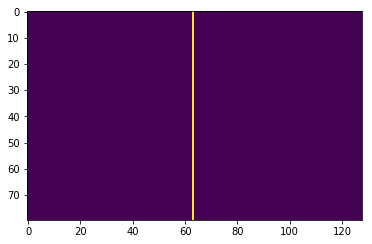

In [359]:
frame = generateToy(1,80,128,1)
imgplot = plt.imshow(frame)

#### Génération des neurones à champs récepteur

In [360]:
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

In [361]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
count,50.0,5.000000e+01,50.000000,50.0,50.00000,50.0,50.0,50.0
mean,7.0,9.999996e-03,242.906311,0.0,51.50000,63.0,0.0,63.0
std,0.0,3.763112e-09,0.000092,0.0,14.57738,0.0,0.0,0.0
min,7.0,1.000000e-02,242.906403,0.0,27.00000,63.0,0.0,63.0
25%,7.0,1.000000e-02,242.906403,0.0,39.25000,63.0,0.0,63.0
50%,7.0,1.000000e-02,242.906403,0.0,51.50000,63.0,0.0,63.0
75%,7.0,1.000000e-02,242.906403,0.0,63.75000,63.0,0.0,63.0
max,7.0,1.000000e-02,242.906403,0.0,76.00000,63.0,0.0,63.0


In [362]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
0,7,0.01,242.906403,0.0,27,63,0,63.0
1,7,0.01,242.906403,0.0,28,63,0,63.0
2,7,0.01,242.906403,0.0,29,63,0,63.0
3,7,0.01,242.906403,0.0,30,63,0,63.0


#### Affichage graphique du champs récepteur des neurones

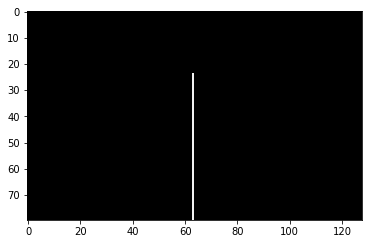

In [363]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

In [364]:
np.max(testBitmap)

242

In [365]:
lintI = 0
while (lintI < 10):
    cv2.imshow('FRAME', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # press q to quit
        break
    lintI += 1

#### Simplification des neurones

In [366]:
np.sum(titi.memory_usage())

2130

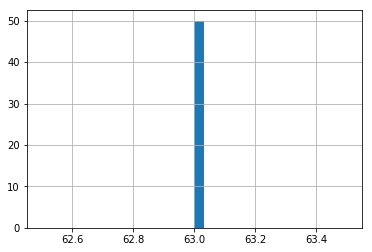

In [367]:
titi.layer.hist(bins=32)

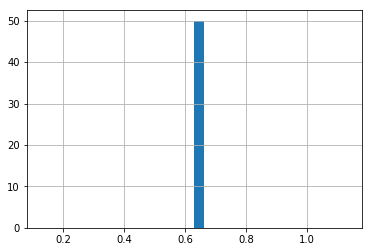

In [368]:
toto = titi.angle*titi.layer
toto.hist(bins=32)

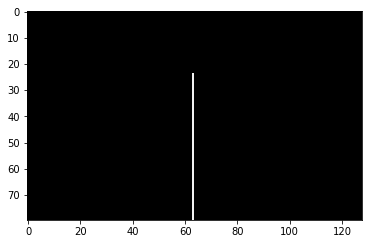

In [371]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap,0,0,60,5)
imgplot = plt.imshow(testBitmap)

#### Génération des groupes

In [35]:
findGroups(titi);

In [36]:
titi.groupby('groupID').agg(['mean', 'count'])[0:5]

longueur       angle            weight       precision        xPos  \
            mean count  mean count        mean count      mean count  mean   
groupID                                                                      
1              7    50  0.01    50  242.906403    50       0.0    50  51.5   

              yPos       layer        
        count mean count  mean count  
groupID                               
1          50   63    50   0.0    50

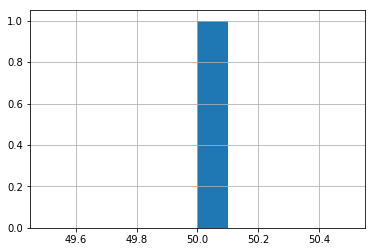

In [37]:
titi.groupby('groupID').size().hist()

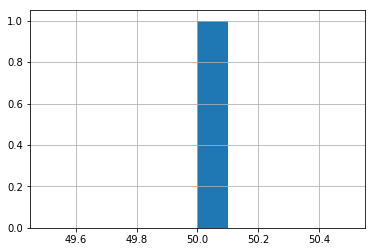

In [38]:
resultGroup = titi.groupby('groupID').size()
resultGroup[resultGroup>10].hist()

In [39]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
count,50.0,5.000000e+01,50.000000,50.0,50.00000,50.0,50.0,50.0
mean,7.0,9.999996e-03,242.906311,0.0,51.50000,63.0,1.0,0.0
std,0.0,3.763112e-09,0.000092,0.0,14.57738,0.0,0.0,0.0
min,7.0,1.000000e-02,242.906403,0.0,27.00000,63.0,1.0,0.0
25%,7.0,1.000000e-02,242.906403,0.0,39.25000,63.0,1.0,0.0
50%,7.0,1.000000e-02,242.906403,0.0,51.50000,63.0,1.0,0.0
75%,7.0,1.000000e-02,242.906403,0.0,63.75000,63.0,1.0,0.0
max,7.0,1.000000e-02,242.906403,0.0,76.00000,63.0,1.0,0.0


In [369]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
0,7,0.01,242.906403,0.0,27,63,0,63.0
1,7,0.01,242.906403,0.0,28,63,0,63.0
2,7,0.01,242.906403,0.0,29,63,0,63.0
3,7,0.01,242.906403,0.0,30,63,0,63.0


### Test 2
#### Generate data of type 2

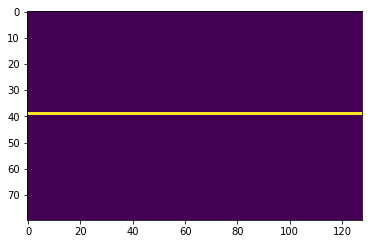

In [42]:
frame = generateToy(2,80,128,1)
imgplot = plt.imshow(frame)

#### Génération des neurones à champs récepteur

In [43]:
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

exceed the limit of the matrix
exceed the limit of the matrix
exceed the limit of the matrix
error 10 : 
lAngleMat
[[-4.499e+01 -3.368e+01 -1.842e+01  1.000e-02  1.844e+01  3.370e+01
   4.501e+01]
 [-5.630e+01 -4.499e+01 -2.656e+01  1.000e-02  2.658e+01  4.501e+01
   5.632e+01]
 [-7.156e+01 -6.342e+01 -4.499e+01  1.000e-02  4.501e+01  6.344e+01
   7.158e+01]
 [ 9.000e+01  9.000e+01  9.000e+01  0.000e+00  9.000e+01  9.000e+01
   9.000e+01]
 [ 7.158e+01  6.344e+01  4.501e+01  1.000e-02 -4.499e+01 -6.342e+01
  -7.156e+01]
 [ 5.632e+01  4.501e+01  2.658e+01  1.000e-02 -2.656e+01 -4.499e+01
  -5.630e+01]
 [ 4.501e+01  3.370e+01  1.844e+01  1.000e-02 -1.842e+01 -3.368e+01
  -4.499e+01]]
lNeuronFieldFrame
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
lintX
39
lintY
125
offsetField
3
error 10 : 
lAngleMat
[[-4.499e+01 -3.368e+01 -1.842e+01  1.000e-02  1.844e+01  3.370e+01
   4.501e+01]
 [-5.63

In [44]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
count,128.0,128.000000,128.000000,128.0,128.000000,128.000000,128.0,128.0
mean,7.0,85.781250,231.520050,0.0,37.171875,60.523438,0.0,0.0
std,0.0,19.098122,51.545200,0.0,8.275863,37.053901,0.0,0.0
min,7.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
25%,7.0,90.000000,242.906403,0.0,39.000000,28.750000,0.0,0.0
50%,7.0,90.000000,242.906403,0.0,39.000000,60.500000,0.0,0.0
75%,7.0,90.000000,242.906403,0.0,39.000000,92.250000,0.0,0.0
max,7.0,90.000000,242.906403,0.0,39.000000,124.000000,0.0,0.0


In [45]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
0,7,0.0,0.000000,0.0,0,0,0,0.0
1,7,0.0,0.000000,0.0,0,0,0,0.0
2,7,0.0,0.000000,0.0,0,0,0,0.0
3,7,90.0,242.906403,0.0,39,3,0,0.0


#### Affichage graphique du champs récepteur des neurones

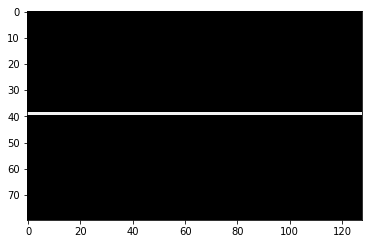

In [46]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

#### Génération des groupes

In [47]:
findGroups(titi);

In [48]:
titi.groupby('groupID').agg(['mean', 'count'])[0:5]

longueur       angle            weight       precision       xPos  \
            mean count  mean count        mean count      mean count mean   
groupID                                                                     
1              7     1   0.0     1    0.000000     1       0.0     1    0   
2              7     1   0.0     1    0.000000     1       0.0     1    0   
3              7     1   0.0     1    0.000000     1       0.0     1    0   
4              7   122  90.0   122  242.906403   122       0.0   122   39   
5              7     1   0.0     1    0.000000     1       0.0     1    0   

               yPos       layer        
        count  mean count  mean count  
groupID                                
1           1   0.0     1   0.0     1  
2           1   0.0     1   0.0     1  
3           1   0.0     1   0.0     1  
4         122  63.5   122   0.0   122  
5           1   0.0     1   0.0     1

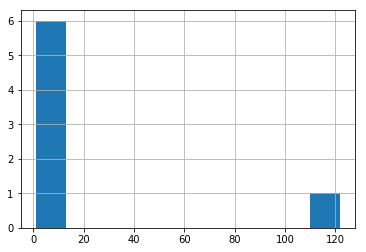

In [49]:
titi.groupby('groupID').size().hist()

In [50]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
0,7,0.0,0.000000,0.0,0,0,1,0.0
1,7,0.0,0.000000,0.0,0,0,2,0.0
2,7,0.0,0.000000,0.0,0,0,3,0.0
3,7,90.0,242.906403,0.0,39,3,4,0.0


### Test 3
#### Generate data of type 3

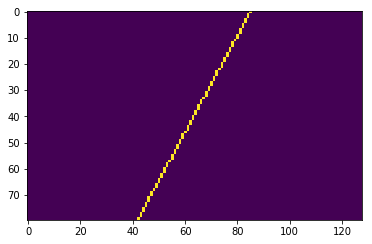

In [51]:
frame = generateToy(3,80,128,1)
imgplot = plt.imshow(frame)

#### Génération des neurones à champs récepteur

In [52]:
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

In [53]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
count,50.0,50.000000,50.000000,50.000000,50.00000,50.000000,50.0,50.0
mean,7.0,26.755207,213.043991,13.634507,51.50000,56.980000,0.0,0.0
std,0.0,2.806284,5.832972,1.934354,14.57738,7.924362,0.0,0.0
min,7.0,25.053333,205.570328,7.588554,27.00000,44.000000,0.0,0.0
25%,7.0,25.053333,212.746216,13.835940,39.25000,50.250000,0.0,0.0
50%,7.0,25.053333,212.746216,13.835940,51.50000,57.000000,0.0,0.0
75%,7.0,27.596666,212.746216,13.835940,63.75000,63.750000,0.0,0.0
max,7.0,35.096668,230.490402,15.747627,76.00000,70.000000,0.0,0.0


In [54]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
0,7,25.053333,212.746216,13.83594,27,70,0,0.0
1,7,25.053333,212.746216,13.83594,28,70,0,0.0
2,7,25.053333,212.746216,13.83594,29,69,0,0.0
3,7,25.053333,212.746216,13.83594,30,69,0,0.0


#### Affichage graphique du champs récepteur des neurones

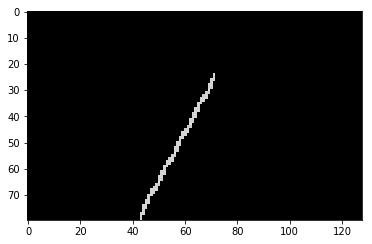

In [55]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

#### Génération des groupes

In [56]:
findGroups(titi);

In [57]:
titi.groupby('groupID').agg(['mean', 'count'])[0:5]

longueur            angle            weight        precision        \
            mean count       mean count        mean count       mean count   
groupID                                                                      
1              7    50  26.755199    50  213.044052    50  13.634507    50   

         xPos         yPos       layer        
         mean count   mean count  mean count  
groupID                                       
1        51.5    50  56.98    50   0.0    50

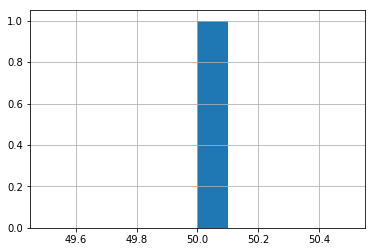

In [58]:
titi.groupby('groupID').size().hist()

### Test 4
#### Generate data of type 4

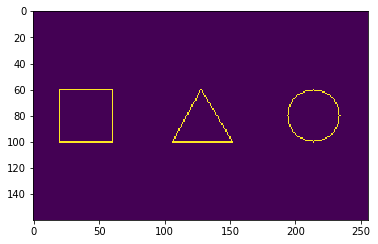

In [737]:
frame = generateToy(4,160,256,1)
imgplot = plt.imshow(frame)

#### Génération des neurones à champs récepteur

In [738]:
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

In [739]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
count,398.0,398.000000,398.000000,398.000000,398.000000,398.000000,398.0,398.000000
mean,7.0,22.983759,214.483398,9.913938,82.311558,117.037688,0.0,161.944717
std,0.0,52.803646,44.123013,11.387993,15.140764,72.832620,0.0,90.397964
min,7.0,-86.926666,10.970448,0.000000,60.000000,20.000000,0.0,-75.000000
25%,7.0,-7.785227,205.570328,0.000000,67.000000,50.000000,0.0,94.000000
50%,7.0,13.627500,230.490402,7.588554,84.000000,120.000000,0.0,160.500000
75%,7.0,90.000000,242.906403,15.747627,99.000000,195.000000,0.0,260.000000
max,7.0,90.000000,242.906403,61.020844,100.000000,234.000000,0.0,317.000000


In [740]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
0,7,45.005001,46.537529,44.994999,60,20,0,62.0
1,7,64.290001,123.892136,30.566092,60,21,0,75.0
2,7,74.018753,176.191147,21.954557,60,22,0,80.0
3,7,79.212219,202.501602,16.500349,60,23,0,82.0


#### Affichage graphique du champs récepteur des neurones

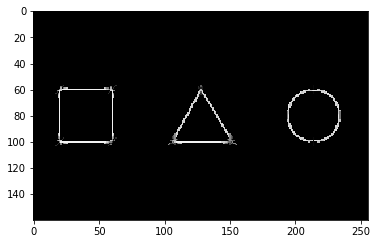

In [741]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

#### Simplification

##### Layer

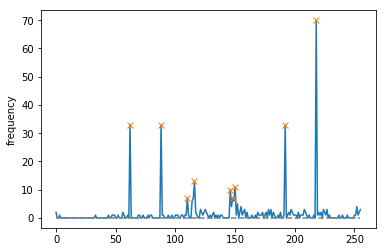

In [871]:
lvhist = (titi['layer']
 .pipe(lambda s: pd.Series(np.histogram(s,  bins=256)))
 .pipe(lambda s: pd.Series(s[0], index=s[1][:-1]))
)
peaks,ldict = find_peaks(lvhist, height=7)
ser = lvhist.to_numpy()
plt.plot(ser)
plt.plot(peaks, ser[peaks], "x")
plt.plot(np.zeros_like(ser), "--", color="gray")
plt.ylabel('frequency')
plt.show()

In [805]:
lidx2 = peaks[np.argmax(ldict['peak_heights'])]
lLayerPic = lvhist.index.values[lidx2:lidx2+1][0]

In [872]:
lidx2 = peaks[3]
lLayerPic = lvhist.index.values[lidx2:lidx2+1][0]

In [788]:
lidx2

218

In [789]:
np.argmax(ldict['peak_heights'])

8

In [803]:
ldict['peak_heights'][8]=0

In [804]:
ldict['peak_heights']

array([33., 33.,  7., 13., 10.,  7., 11., 33.,  0.])

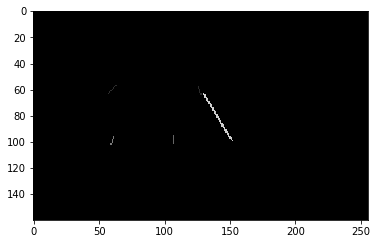

In [873]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap,0,0,lLayerPic,5)
imgplot = plt.imshow(testBitmap)

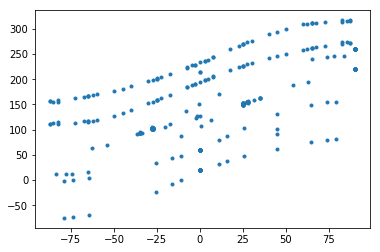

In [753]:
plt.plot(titi.angle,titi.layer,'.')
plt.show()

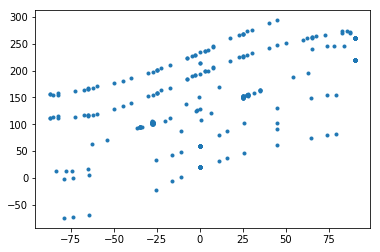

In [754]:
plt.plot(titi.angle[np.abs(titi.layer)<300],titi.layer[np.abs(titi.layer)<300],'.')
plt.show()

##### Angle

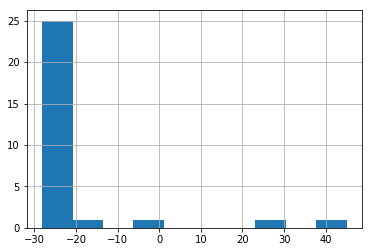

In [874]:
lNeuronTopLayer = titi[(titi.layer>=(lLayerPic-5)) &(titi.layer<=(lLayerPic+5))]
lNeuronTopLayer.angle.hist()

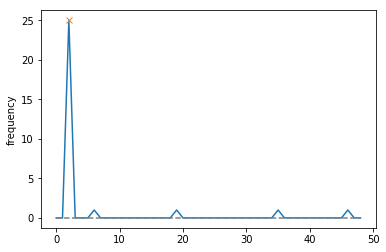

In [877]:
lvhist = (lNeuronTopLayer['angle']
 .pipe(lambda s: pd.Series(np.histogram(s,  bins=45)))
 .pipe(lambda s: pd.Series(s[0], index=s[1][:-1]))
)
lvhist = lvhist.append(pd.Series([0, 0]))
ltt  = pd.Series([0, 0])
lvhist = ltt.append(lvhist)
peaks,ldict = find_peaks(lvhist, height=7)
ser = lvhist.to_numpy()
plt.plot(ser)
plt.plot(peaks, ser[peaks], "x")
plt.plot(np.zeros_like(ser), "--", color="gray")
plt.ylabel('frequency')
plt.show()

In [878]:
lidx2 = peaks[np.argmax(ldict['peak_heights'])]
lAnglePic = lvhist.index.values[lidx2:lidx2+1][0]

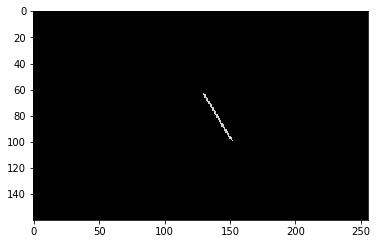

In [879]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap,0,0,lLayerPic,5,lAnglePic,5)
imgplot = plt.imshow(testBitmap)

number of group found : 9
Layer = 154.6875
Angle = 23.832590103149414
Number of neurons in this group : 24


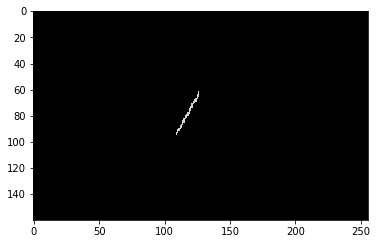

In [906]:
lTMPNeuronList = getMainNeurons(titi,5,True)

testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(lTMPNeuronList, testBitmap,0,0)
imgplot = plt.imshow(testBitmap)

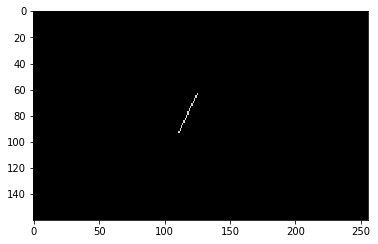

In [923]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(getLineNeuron(lTMPNeuronList), testBitmap,0,0)
imgplot = plt.imshow(testBitmap)

In [984]:
lTMPNeuronList = getLineNeuronList(titi)
print(lTMPNeuronList)

   longueur      angle      weight  precision   xPos   yPos  groupID  layer
0     122.0  90.000008  242.906433   0.000000  100.0   86.0        0    0.0
1      32.0   0.010000  242.906403   0.000000   80.0   20.0        1    0.0
2      32.0   0.010000  242.906403   0.000000   80.0   60.0        2    0.0
3      32.0  90.000000  242.906403   0.000000   60.0   40.0        3    0.0
4      35.0 -27.846771  209.158417  14.790317   81.0  140.0        4    0.0
5      30.0  26.443127  211.040039  14.289734   78.0  118.0        5    0.0
6      36.0  25.218536  212.360291  13.938755   82.0  116.0        6    0.0
7      38.0 -35.090321  223.318420   9.697017   77.0  138.0        7    0.0
8      36.0  26.201864  211.336288  14.210956   81.0  117.0        8    0.0


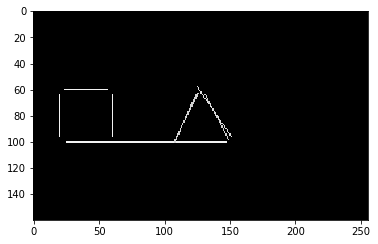

In [986]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(lTMPNeuronList, testBitmap,0,0)
imgplot = plt.imshow(testBitmap)

#### Génération des groupes

In [64]:
findGroups(titi);

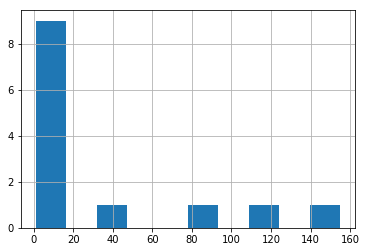

In [65]:
titi.groupby('groupID').size().hist()

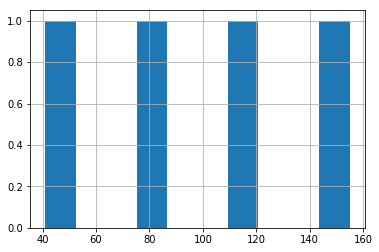

In [66]:
resultGroup = titi.groupby('groupID').size()
resultGroup[resultGroup>10].hist()

In [67]:
titi.groupby('groupID').agg(['mean', 'count'])[resultGroup>10]

longueur            angle            weight        precision        \
            mean count       mean count        mean count       mean count   
groupID                                                                      
1              7   155  40.768021   155  229.658386   155   3.791248   155   
6              7    83  48.416748    83  211.846710    83  10.593689    83   
9              7    41 -21.370747    41  187.712830    41  18.333818    41   
10             7   110   0.008000   110  214.484055   110  12.641945   110   

              xPos              yPos       layer        
              mean count        mean count  mean count  
groupID                                                 
1        80.638710   155   39.393548   155   0.0   155  
6        90.156627    83  122.337349    83   0.0    83  
9        80.902439    41  140.390244    41   0.0    41  
10       80.000000   110  214.000000   110   0.0   110

In [68]:
for lidx, langle in titi.groupby('groupID').count().sort_values('angle', ascending=False).iterrows():
    print (lidx)

1
10
6
9
2
3
4
5
7
8
11
12
13


In [69]:
getWAGA(titi,6)

54.005035400390625

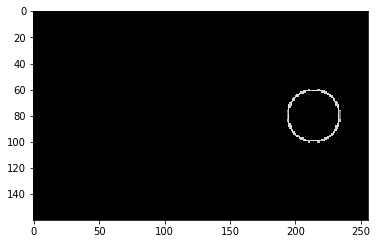

In [70]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap,0,10)
imgplot = plt.imshow(testBitmap)

### Test 5
#### Generate data of type 5

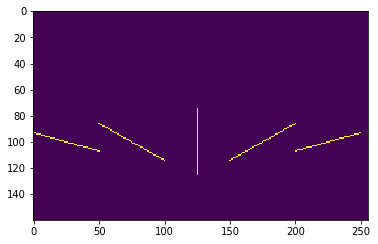

In [345]:
frame = generateToy(5,160,256,1)
imgplot = plt.imshow(frame) 

#### Génération des neurones à champs récepteur

In [346]:
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

In [347]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
count,225.0,225.000000,225.000000,225.000000,225.000000,225.000000,225.0,225.000000
mean,7.0,0.007630,218.586960,10.958316,100.000000,125.000000,0.0,125.000000
std,0.0,62.412056,14.312121,5.934726,7.781044,71.818223,0.0,751.482971
min,7.0,-79.423332,200.650269,0.000000,78.000000,3.000000,0.0,-1226.000000
25%,7.0,-64.948334,206.338470,10.909474,95.000000,64.000000,0.0,-418.000000
50%,7.0,0.010000,212.899750,13.792321,100.000000,125.000000,0.0,125.000000
75%,7.0,64.964996,222.082733,15.553707,105.000000,186.000000,0.0,668.000000
max,7.0,79.433334,242.906403,16.938763,122.000000,247.000000,0.0,1476.000000


In [348]:
titi.groupby('angle').agg(['mean', 'count'])

longueur            weight        precision       xPos       yPos  \
               mean count        mean count       mean count mean count mean   
angle                                                                          
-79.423332        7    16  222.054947    16  10.919160    16  100    16   25   
-74.995003        7    14  200.650269    14  16.938763    14  100    14   25   
-74.993332        7     5  221.475922     5  11.119500     5  100     5   25   
-71.921669        7    10  206.338470    10  15.553707    10  100    10   25   
-64.948334        7    20  212.735580    20  13.838958    20  100    20   75   
-62.404999        7    10  212.899750    10  13.792321    10  100    10   75   
-61.876667        7    10  205.558472    10  15.750603    10  100    10   75   
-54.903332        7     5  230.490402     5   7.588554     5  100     5   75   
 0.010000         7    45  242.906403    45   0.000000    45  100    45  125   
 54.923332        7     5  230.490402     5   7.588554     5  100     5  175   
 61.893333        7    10  205.582184    10  15.744652    10  100    10  175   
 62.421665        7    10  212.923187    10  13.785652    10  100    10  175   
 64.964996        7    20  212.756851    20  13.832924    20  100    20  175   
 71.934998        7    10  206.368973    10  15.545959    10  100    10  225   
 75.004997        7    14  200.688141    14  16.929905    14  100    14  225   
 75.006668        7     5  221.502106     5  11.110503     5  100     5  225   
 79.433334        7    16  222.082733    16  10.909474    16  100    16  225   

                 groupID              layer        
           count    mean count         mean count  
angle                                              
-79.423332    16       0    16 -1175.000000    16  
-74.995003    14       0    14  -846.000000    14  
-74.993332     5       0     5  -845.599976     5  
-71.921669    10       0    10  -693.000000    10  
-64.948334    20       0    20  -425.000000    20  
-62.404999    10       0    10  -363.799988    10  
-61.876667    10       0    10  -363.799988    10  
-54.903332     5       0     5  -258.200012     5  
 0.010000     45       0    45   125.000000    45  
 54.923332     5       0     5   508.200012     5  
 61.893333    10       0    10   613.799988    10  
 62.421665    10       0    10   613.799988    10  
 64.964996    20       0    20   675.000000    20  
 71.934998    10       0    10   943.000000    10  
 75.004997    14       0    14  1096.000000    14  
 75.006668     5       0     5  1095.599976     5  
 79.433334    16       0    16  1425.000000    16

#### Affichage graphique du champs récepteur des neurones

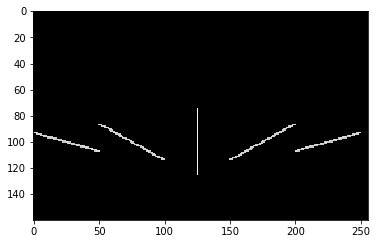

In [349]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

#### Simplification

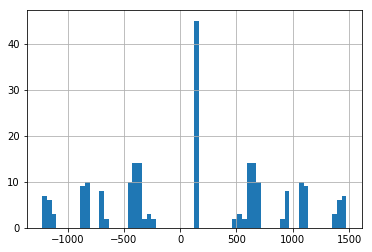

In [350]:
titi.layer.hist(bins=64)

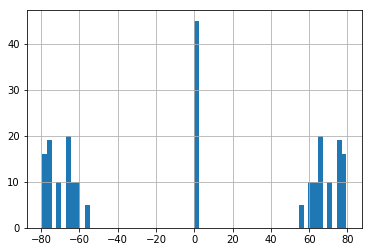

In [351]:
titi.angle.hist(bins=64)

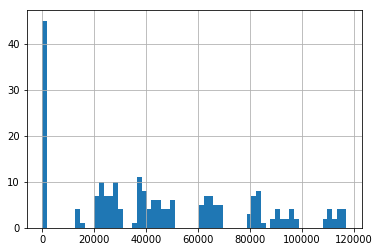

In [358]:
toto = titi.angle*titi.layer
toto.hist(bins=64)

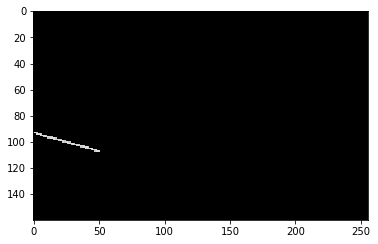

In [357]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap,0,0,-1300,500)
imgplot = plt.imshow(testBitmap)

#### Génération des groupes

In [76]:
findGroups(titi);

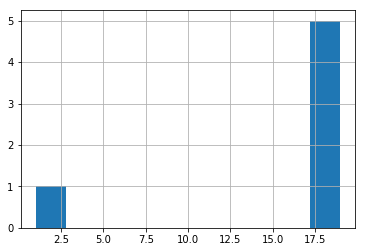

In [77]:
titi.groupby('groupID').size().hist()

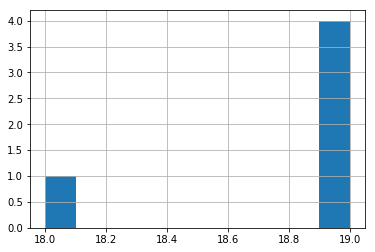

In [78]:
resultGroup = titi.groupby('groupID').size()
resultGroup[resultGroup>10].hist()

In [79]:
titi.groupby('groupID').agg(['mean', 'count'])[resultGroup>10]

longueur            angle            weight        precision        \
            mean count       mean count        mean count       mean count   
groupID                                                                      
1              7    19   0.010000    19  242.906403    19   0.000000    19   
2              7    19 -61.589123    19  213.324356    19  13.441002    19   
3              7    18  61.419720    18  213.376328    18  13.413681    18   
4              7    19 -77.325699    19  211.915894    19  13.770551    19   
5              7    19  77.335701    19  211.948456    19  13.761257    19   

              xPos              yPos       layer        
              mean count        mean count  mean count  
groupID                                                 
1        50.000000    19   62.000000    19   0.0    19  
2        49.947368    19   37.000000    19   0.0    19  
3        49.777778    18   87.444444    18   0.0    18  
4        49.894737    19   12.000000    19   0.0    19  
5        50.105263    19  112.000000    19   0.0    19

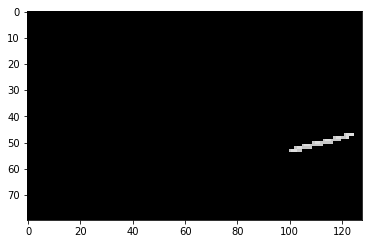

In [80]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap,0,5)
imgplot = plt.imshow(testBitmap)

In [81]:
getWAGA(titi,5)

77.44712829589844

### Test 6
#### Generate data of type 6

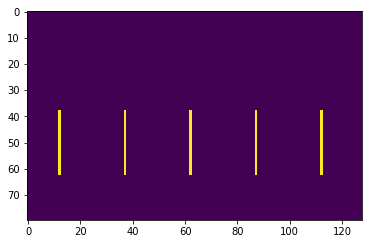

In [82]:
frame = generateToy(6,80,128,1)
imgplot = plt.imshow(frame) 

#### Génération des neurones à champs récepteur

In [83]:
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

In [84]:
titi.groupby('angle').agg(['mean', 'count'])

longueur            weight       precision       xPos       yPos        \
          mean count        mean count      mean count mean count mean count   
angle                                                                          
0.01         7    95  242.906403    95       0.0    95   50    95   62    95   

      groupID       layer        
         mean count  mean count  
angle                            
0.01        0    95   0.0    95

#### Affichage graphique du champs récepteur des neurones

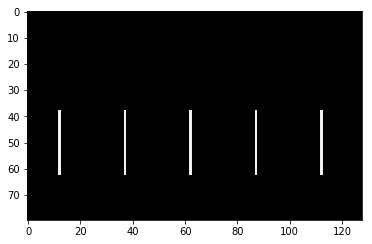

In [85]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

#### Génération des groupes

In [86]:
findGroups(titi);

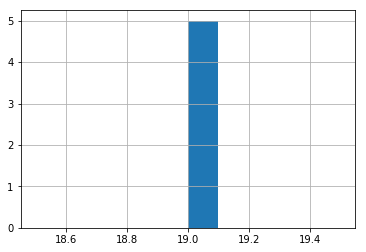

In [87]:
titi.groupby('groupID').size().hist()

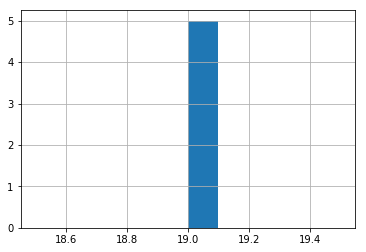

In [88]:
resultGroup = titi.groupby('groupID').size()
resultGroup[resultGroup>10].hist()

In [89]:
titi.groupby('groupID').agg(['mean', 'count'])[resultGroup>10]

longueur       angle            weight       precision       xPos  \
            mean count  mean count        mean count      mean count mean   
groupID                                                                     
1              7    19  0.01    19  242.906403    19       0.0    19   50   
2              7    19  0.01    19  242.906403    19       0.0    19   50   
3              7    19  0.01    19  242.906403    19       0.0    19   50   
4              7    19  0.01    19  242.906403    19       0.0    19   50   
5              7    19  0.01    19  242.906403    19       0.0    19   50   

              yPos       layer        
        count mean count  mean count  
groupID                               
1          19   12    19   0.0    19  
2          19   37    19   0.0    19  
3          19   62    19   0.0    19  
4          19   87    19   0.0    19  
5          19  112    19   0.0    19

### Test 7
#### Generate data of type 7

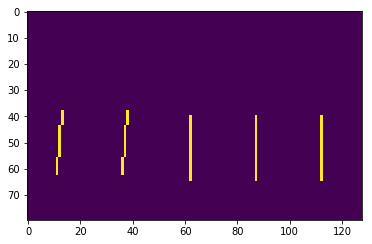

In [90]:
frame = generateToy(7,80,128,1)
imgplot = plt.imshow(frame) 

#### Génération des neurones à champs récepteur

In [91]:
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

In [92]:
titi.groupby('angle').agg(['mean', 'count'])

longueur            weight        precision             xPos        \
              mean count        mean count       mean count       mean count   
angle                                                                          
0.010000         7    71  242.906403    71   0.000000    71  51.774648    71   
3.081667         7     8  232.039963     8   6.868455     8  49.500000     8   
7.510000         7     8  222.213516     8  10.863776     8  49.500000     8   
15.010000        7     8  200.669205     8  16.934334     8  49.500000     8   

                yPos       groupID       layer        
                mean count    mean count  mean count  
angle                                                 
0.010000   74.647887    71       0    71   0.0    71  
3.081667   24.500000     8       0     8   0.0     8  
7.510000   24.500000     8       0     8   0.0     8  
15.010000  24.500000     8       0     8   0.0     8

#### Affichage graphique du champs récepteur des neurones

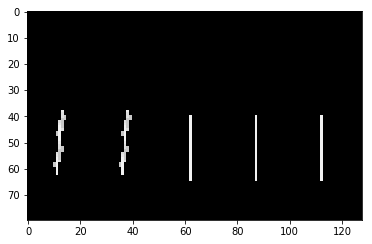

In [93]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

#### Génération des groupes

In [94]:
findGroups(titi);

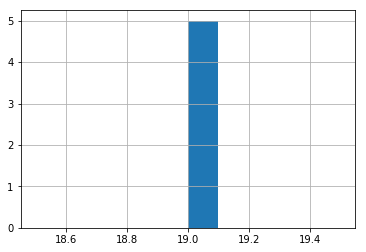

In [95]:
titi.groupby('groupID').size().hist()

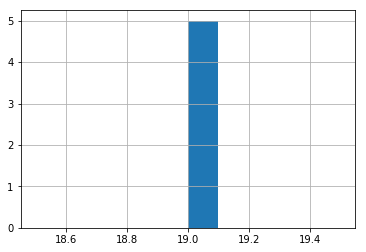

In [96]:
resultGroup = titi.groupby('groupID').size()
resultGroup[resultGroup>10].hist()

In [97]:
titi.groupby('groupID').agg(['mean', 'count'])[resultGroup>10]

longueur           angle            weight       precision       xPos  \
            mean count      mean count        mean count      mean count mean   
groupID                                                                         
1              7    19  5.393509    19  227.370285    19  7.298224    19   50   
2              7    19  5.393509    19  227.370285    19  7.298224    19   50   
3              7    19  0.010000    19  242.906403    19  0.000000    19   52   
4              7    19  0.010000    19  242.906403    19  0.000000    19   52   
5              7    19  0.010000    19  242.906403    19  0.000000    19   52   

                     yPos       layer        
        count        mean count  mean count  
groupID                                      
1          19   11.947368    19   0.0    19  
2          19   36.947368    19   0.0    19  
3          19   62.000000    19   0.0    19  
4          19   87.000000    19   0.0    19  
5          19  112.000000    19   0.0    19

In [98]:
getWAGA(titi,2)

5.000133991241455

### Test 8 : video frame
#### Get Video frame

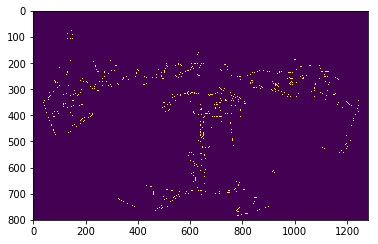

In [99]:
frame = Cannyframe
imgplot = plt.imshow(frame)

#### Génération des neurones à champs récepteur

In [100]:
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

In [101]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
count,6452.0,6452.000000,6452.000000,6452.000000,6452.000000,6452.000000,6452.0,6452.0
mean,7.0,4.998969,157.106003,24.906563,445.457688,650.464197,0.0,0.0
std,0.0,50.678619,72.648529,16.812843,153.752807,297.094736,0.0,0.0
min,7.0,-87.365715,2.718763,0.000000,267.000000,39.000000,0.0,0.0
25%,7.0,-34.992499,120.865974,14.346698,325.000000,523.000000,0.0,0.0
50%,7.0,0.010000,182.490227,20.770247,388.500000,653.000000,0.0,0.0
75%,7.0,48.726250,210.914810,31.041572,549.000000,789.000000,0.0,0.0
max,7.0,90.000000,242.906403,75.303673,784.000000,1246.000000,0.0,0.0


In [102]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,groupID,layer
0,7,-14.990000,200.669205,16.934334,267,82,0,0.0
1,7,-21.908571,169.895966,23.086880,267,180,0,0.0
2,7,-40.563332,112.282188,32.398540,267,191,0,0.0
3,7,23.696667,157.390488,25.222450,267,281,0,0.0


#### Affichage graphique du champs récepteur des neurones

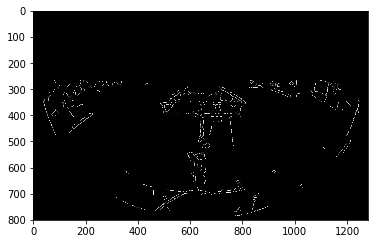

In [103]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

In [104]:
lintI = 0
while (lintI < 10):
    cv2.imshow('testBitmap', testBitmap)
    if cv2.waitKey(1) & 0xFF == ord('q'): # press q to quit
        break
    lintI += 1

##### Affichage de la frame :

![Edge detection frame image, with the Canny Algorithm](frame01.png)

##### Affichage des champs récepteurs des neurones

![NeuronField Image : Le niveau de gris correspond au niveau d'activation du neurone](neuronField01.png)


#### Génération des groupes

In [105]:
findGroups(titi);

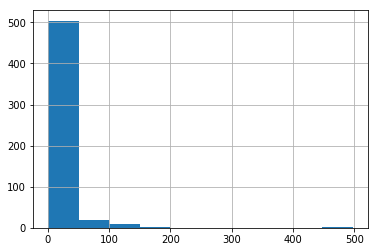

In [106]:
titi.groupby('groupID').size().hist()

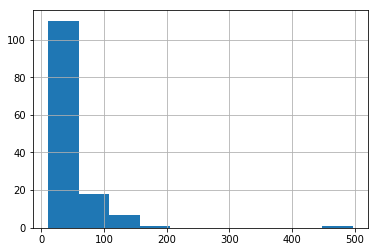

In [107]:
resultGroup = titi.groupby('groupID').size()
resultGroup[resultGroup>10].hist()

In [108]:
titi.groupby('groupID').agg(['mean', 'count'])[resultGroup>130]

longueur            angle            weight        precision        \
            mean count       mean count        mean count       mean count   
groupID                                                                      
136            7   497  26.611830   497  174.087921   497  19.788208   497   
201            7   151  12.489170   151  182.971664   151  18.340914   151   
203            7   149 -15.760202   149  174.091461   149  21.210890   149   
211            7   152  18.596670   152  175.904434   152  21.124544   152   
443            7   181  63.175495   181  197.623657   181  15.064166   181   

               xPos               yPos       layer        
               mean count         mean count  mean count  
groupID                                                   
136      361.372233   497   574.227364   497   0.0   497  
201      354.079470   151   765.158940   151   0.0   151  
203      406.140940   149    59.134228   149   0.0   149  
211      407.828947   152  1226.342105   152   0.0   152  
443      691.972376   181   731.281768   181   0.0   181

# Errors list

## Error 10
Problème dans la fonction [getNeuronActivationList](#Création-d'une-liste-de-neurones-à-champs-récepteurs)


